In [1]:
import shap
import transformers
import torch
import numpy as np
import pandas as pd
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

In [2]:
# load a BERT model
model_name = "bert-base-multilingual-cased"
tokenizer = transformers.BertTokenizer.from_pretrained(model_name)
model = transformers.BertForSequenceClassification.from_pretrained(model_name, num_labels=2).cuda()

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [2]:
# load a XLM-Roberta model
model_name = "xlm-roberta-base"
tokenizer = transformers.XLMRobertaTokenizer.from_pretrained(model_name)
model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_name, num_labels=2).cuda()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_p

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

In [3]:
dataset = {'label' : [], 'text': []}
f = open("./IronyTR Dataset/ironic.txt", "r",  encoding="utf8")
lines = f.readlines()

for line in lines:
    dataset['text'].append(line)
    dataset['label'].append(1)
    
f.close()

f = open("./IronyTR Dataset/non-ironic.txt", "r",  encoding="utf8")
lines = f.readlines()

for line in lines:
    dataset['text'].append(line)
    dataset['label'].append(0)
    
f.close()

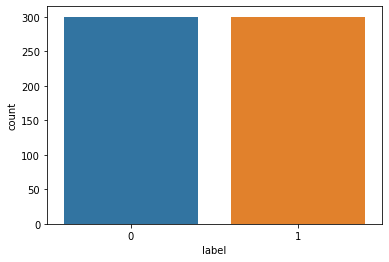

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=dataset['label'])
plt.xlabel('label');

# Choosing Sequence Length

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


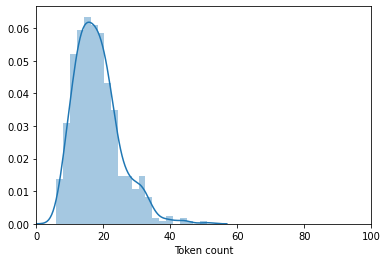

In [5]:
token_lens = []

for txt in dataset['text']:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))
    
sns.distplot(token_lens)
plt.xlim([0, 100]);
plt.xlabel('Token count');

In [6]:
MAX_LEN = 90

X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['label'], test_size=0.3, random_state=42, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle=True)
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=MAX_LEN)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=MAX_LEN)

In [7]:
print(len(X_train), (len(X_val), len(X_test)))

420 (90, 90)


In [8]:
X_train_tokenized.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [9]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [10]:
# ----- 2. Fine-tune pretrained model -----#
# Define Trainer parameters
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
# Define Trainer
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
    learning_rate=2e-5,
)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

# Train pre-trained model
trainer.train()

In [12]:
trainer.evaluate()

{'eval_loss': 0.6689066886901855,
 'eval_accuracy': 0.6444444444444445,
 'eval_precision': 0.6538461538461539,
 'eval_recall': 0.7083333333333334,
 'eval_f1': 0.68,
 'eval_runtime': 0.1239,
 'eval_samples_per_second': 726.444,
 'epoch': 3.0,
 'eval_mem_cpu_alloc_delta': 438272,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_peaked_delta': 19202048}

In [13]:
model_path = "output/dbmdz_checkpoint-50000"
model.save_pretrained(model_path)

In [14]:
# ----- 3. Predict -----#
# Load test data
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=MAX_LEN)

# Create torch dataset
test_dataset = Dataset(X_test_tokenized)

# Load trained model
#model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).cuda()
#model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_path, num_labels=2).cuda()
#model = transformers.BertForSequenceClassification.from_pretrained(model_path, num_labels=2).cuda()

# Define test trainer
test_trainer = Trainer(model)

# Make prediction
raw_pred, _, _ = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [15]:
# BERT multilingual prediction results
p = tuple((raw_pred, y_test))
compute_metrics(p)

{'accuracy': 0.5555555555555556,
 'precision': 0.6785714285714286,
 'recall': 0.38,
 'f1': 0.48717948717948717}

In [16]:
# XLM-Roberta prediction results
p = tuple((raw_pred, y_test))
compute_metrics(p)

{'accuracy': 0.6111111111111112,
 'precision': 0.6829268292682927,
 'recall': 0.56,
 'f1': 0.6153846153846154}

In [15]:
# dbmdz/Turkish-Bert prediction results
p = tuple((raw_pred, y_test))
compute_metrics(p)

{'accuracy': 0.6,
 'precision': 0.6590909090909091,
 'recall': 0.58,
 'f1': 0.6170212765957446}

# Explain Bert Model with Shap 

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
model_path = "output/bert_checkpoint-50000"
#model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=2).cuda()
#model = transformers.XLMRobertaForSequenceClassification.from_pretrained(model_path, num_labels=2).cuda()
#model = transformers.BertForSequenceClassification.from_pretrained(model_path, num_labels=2).cuda()

In [17]:
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=MAX_LEN, truncation=True) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

In [18]:
# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

explainers.Partition is still in an alpha state, so use with caution...


In [19]:
data = {'text': X_test, 'label': y_test}
df = pd.DataFrame(data)
shap_values = explainer(data, fixed_context=1)

Partition explainer: 91it [00:10,  1.35s/it]


# BERT Multilingual

In [20]:
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

In [21]:
# plot the first sentence's explanation
shap.plots.text(shap_values[1])

In [22]:
# plot the first sentence's explanation
shap.plots.text(shap_values[2])

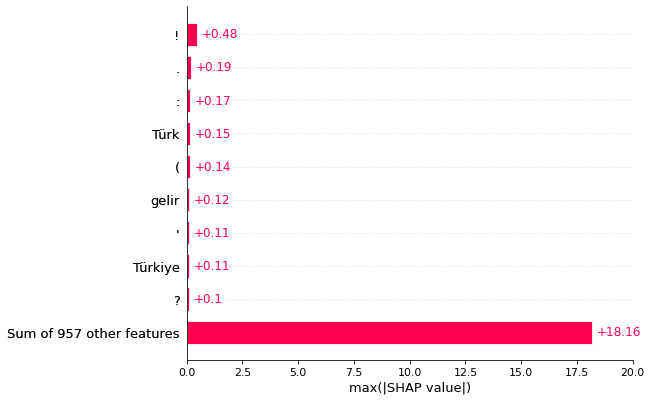

In [23]:
shap.plots.bar(shap_values.abs.max(0))

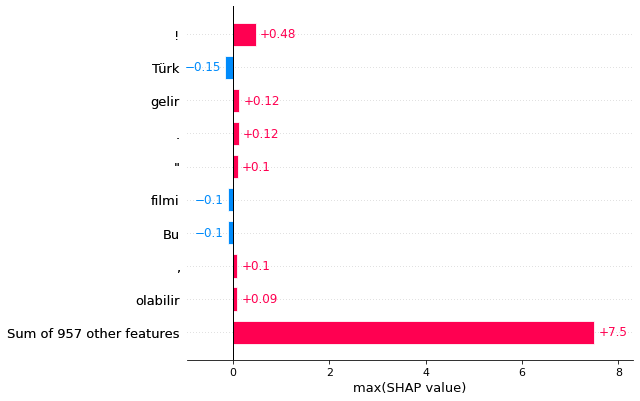

In [24]:
shap.plots.bar(shap_values.max(0))

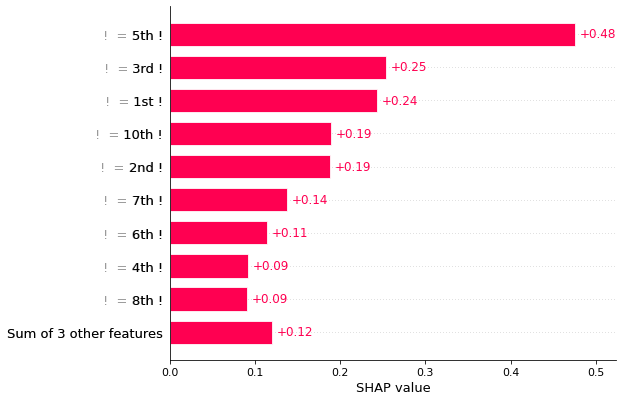

In [25]:
shap.plots.bar(shap_values[:,"!"])

# XLM-Roberta

In [22]:
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

In [23]:
# plot the first sentence's explanation
shap.plots.text(shap_values[1])

In [24]:
# plot the first sentence's explanation
shap.plots.text(shap_values[2])

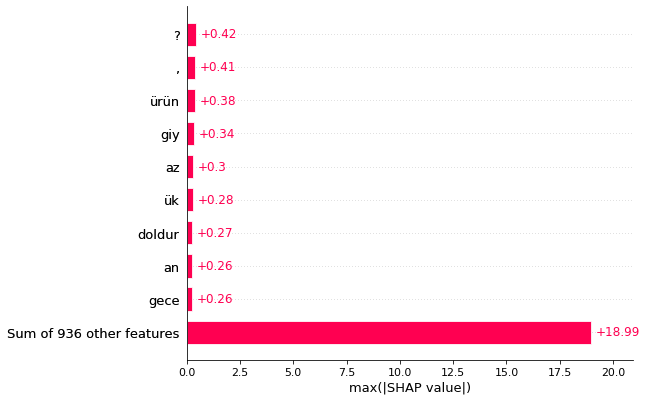

In [25]:
shap.plots.bar(shap_values.abs.max(0))

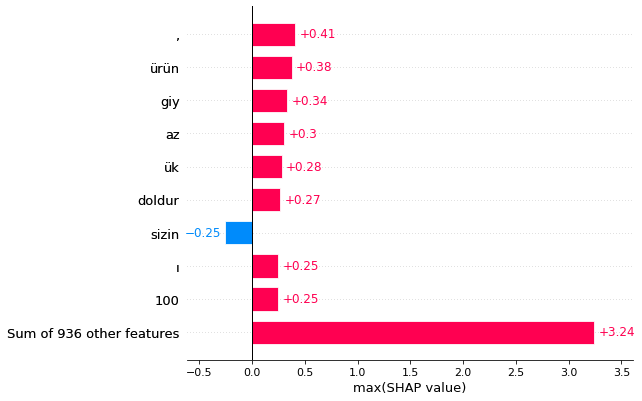

In [26]:
shap.plots.bar(shap_values.max(0))

# Turkish Bert

In [20]:
# plot the first sentence's explanation
shap.plots.text(shap_values[0])

In [21]:
# plot the first sentence's explanation
shap.plots.text(shap_values[1])

In [22]:
# plot the first sentence's explanation
shap.plots.text(shap_values[2])

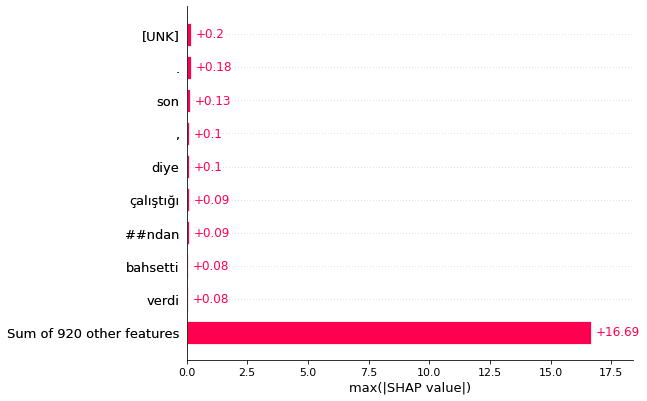

In [23]:
shap.plots.bar(shap_values.abs.max(0))

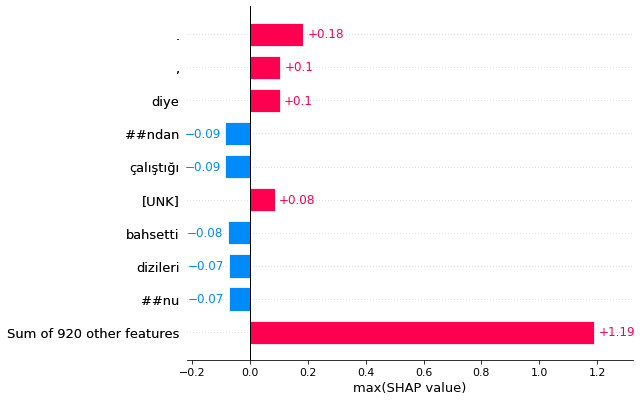

In [24]:
shap.plots.bar(shap_values.max(0))

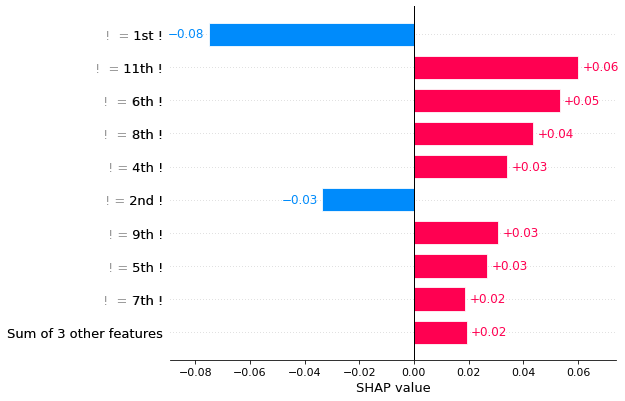

In [25]:
shap.plots.bar(shap_values[:,"!"])